# Schneider challenge

## Dataset

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, random_split

def process_dataset(csv):
  df = pd.read_csv(csv)

  cols_to_use = list(range(1,16))
  X = df.iloc[:, cols_to_use].values.astype(np.float32)
  y = df.iloc[:, 16].values  # última columna es el target

  features_tensor = torch.from_numpy(X)
  labels_tensor = torch.from_numpy(y)
  full_dataset = TensorDataset(features_tensor, labels_tensor)

  train_data, test_data = create_dataset(full_dataset)
  return train_data, test_data

def create_dataset(full_dataset):
    train_dataset, test_dataset = random_split(full_dataset, [0.8,0.2])
    return train_dataset, test_dataset

## Dataloader

In [ ]:
from torch.utils.data import DataLoader

def create_dataloader(train_dataset, test_dataset, BATCH_SIZE):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
    return train_loader, test_loader

## Model

In [ ]:
import torch.nn as nn

class SchneiderModel(nn.Module):
    def __init__(self, inputs=15, outputs=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(inputs, 1500),
            nn.LeakyReLU(),
            nn.Linear(1500, 750),
            nn.LeakyReLU(),
            nn.Linear(750, 375),
            nn.LeakyReLU(),
            nn.Linear(375, 190),
            nn.LeakyReLU(),
            nn.Linear(190, 95),
            nn.LeakyReLU(),
            nn.Linear(95, 30),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(30, outputs)
        )

    def forward(self, X):
        return self.features(X)

## SHAP NN

In [ ]:

def shap_nn_model(model, X_train, X_test, device,
                  feature_names=None,
                  background_size=300,
                  sample_size=300):

    model.eval()

    X_train = np.array(X_train, dtype=np.float32)
    X_test  = np.array(X_test, dtype=np.float32)

    n_train = X_train.shape[0]
    n_test  = X_test.shape[0]

    background_size = min(background_size, n_train)
    idx_bg = np.random.choice(n_train, size=background_size, replace=False)
    X_bg_np = X_train[idx_bg]

    sample_size = min(sample_size, n_test)
    idx_explain = np.random.choice(n_test, size=sample_size, replace=False)
    X_explain_np = X_test[idx_explain]

    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

    X_bg = torch.from_numpy(X_bg_np).to(device)
    X_explain = torch.from_numpy(X_explain_np).to(device)

    explainer = shap.DeepExplainer(model, X_bg)
    shap_values = explainer.shap_values(X_explain)
    expected_value = explainer.expected_value

    if isinstance(shap_values, list):
        class_idx = 1 if len(shap_values) > 1 else 0
        sv = np.array(shap_values[class_idx])
        if isinstance(expected_value, (list, np.ndarray)):
            base_val = float(np.array(expected_value)[class_idx])
        else:
            base_val = float(expected_value)
    else:
        sv = np.array(shap_values)
        if sv.ndim == 3:
            class_idx = 1 if sv.shape[-1] > 1 else 0
            sv = sv[..., class_idx]
            if isinstance(expected_value, (list, np.ndarray)):
                base_val = float(np.array(expected_value)[class_idx])
            else:
                base_val = float(expected_value)
        else:
            if isinstance(expected_value, (list, np.ndarray)):
                class_idx = 1 if len(expected_value) > 1 else 0
                base_val = float(np.array(expected_value)[class_idx])
            else:
                base_val = float(expected_value)


    print("\n[NN] SHAP - Importancia media de las features (|SHAP|)")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        sv,
        X_explain_np,
        feature_names=feature_names,
        plot_type="bar",
        show=True
    )

    print("\n[NN] SHAP - Beeswarm")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        sv,
        X_explain_np,
        feature_names=feature_names,
        show=True
    )

    print("\n[NN] SHAP - Waterfall ejemplo 0 (clase positiva)")
    exp = shap.Explanation(
        values=sv[0],
        base_values=base_val,
        data=X_explain_np[0],
        feature_names=feature_names
    )
    shap.plots.waterfall(exp)

## Train

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train(dataloader,model,loss_fn,optimizer,device, EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for epoch in range(EPOCHS):
        train_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
        for X, y in train_bar:
            X,y = X.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred,y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

            train_bar.set_postfix(loss=running_loss/total, accuracy=100. * correct/total)

        tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}] "
                f"Train Loss: {running_loss/total:.4f} | Train Acc: {100. * correct/total:.4f} ")
    torch.save(model.state_dict(), "schneider_model.pth")
    tqdm.write(f"Training complete. Model saved as schneider_model.pth")


## Test

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def test(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            test_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == y).sum().item()
            test_total += y.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss = test_loss / test_total
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['failed', 'succeed']))

    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(all_labels, all_preds)

    class_names = ['failed', 'succeed']

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    plt.title('Confusion Matrix')
    plt.show()

## Decision Tree

In [ ]:
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

def decision_tree_model(X_train, y_train, X_test, y_test, feature_names=None):
    classifier = tree.DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=15,
        min_samples_leaf=10,
        random_state=42
    )

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Decision Tree Accuracy: {acc:.4f}")

    print("\nDecision Tree Classification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=['failed', 'succeed'],
        zero_division=0
    ))

    # Visualizar árbol
    plt.figure(figsize=(20, 10))
    if feature_names is None:
        feature_names_plot = [f'Feature_{i}' for i in range(X_train.shape[1])]
    else:
        feature_names_plot = feature_names

    tree.plot_tree(
        classifier,
        filled=True,
        feature_names=feature_names_plot,
        class_names=['failed', 'succeed'],
        rounded=True
    )
    plt.show()

    # Matriz de confusión
    ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=['failed', 'succeed']
    )
    plt.show()

    return classifier



In [ ]:
from lime.lime_tabular import LimeTabularExplainer

def lime_explain_sklearn_model(explainer, model, X_test, feature_names, class_names,
                               instance_index=0, num_features=10):
    """
    Genera una explicación LIME para un modelo sklearn (DecisionTree, RandomForest, etc.)
    sobre una instancia concreta de X_test.
    """
    instance = X_test[instance_index]

    predict_fn = model.predict_proba

    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_fn,
        num_features=num_features,
        top_labels=1
    )

    # Mostrar en consola y devolver el objeto exp por si quieres guardarlo o plotear
    print(f"\nLIME para sklearn model en índice {instance_index}")
    print(exp.as_list(label=1))  # contribuciones hacia la clase 1 ('succeed', por ejemplo)

    # Si quieres visualizar como gráfico:
    fig = exp.as_pyplot_figure(label=1)
    import matplotlib.pyplot as plt
    plt.tight_layout()
    plt.show()

    return exp


ModuleNotFoundError: No module named 'lime'

In [ ]:
import torch.nn.functional as F

def make_nn_predict_proba(model, device):
    """
    Devuelve una función tipo predict_proba(X) para usar con LIME
    a partir de un modelo PyTorch entrenado.
    """

    def predict_proba(X):
        """
        X: np.ndarray de forma (n_samples, n_features)
        return: np.ndarray (n_samples, n_classes) con probabilidades
        """
        model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X.astype(np.float32)).to(device)
            logits = model(X_tensor)             # (n_samples, n_classes)
            probs = F.softmax(logits, dim=1)     # convertir a probabilidades
            return probs.cpu().numpy()

    return predict_proba


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

def lime_explain_nn_model(explainer, model, device, X_test, feature_names, class_names,
                          instance_index=0, num_features=10):
    """
    Genera una explicación LIME para la red neuronal SchneiderModel
    sobre una instancia concreta de X_test.
    """
    instance = X_test[instance_index]

    predict_fn = make_nn_predict_proba(model, device)

    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_fn,
        num_features=num_features,
        top_labels=1
    )

    print(f"\nLIME para NN en índice {instance_index}")
    print(exp.as_list(label=1))  # contribuciones hacia la clase 1 ('succeed')

    import matplotlib.pyplot as plt
    fig = exp.as_pyplot_figure(label=1)
    plt.tight_layout()
    plt.show()

    return exp


## Decision Tree SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

def shap_tree_model(classifier, X_test, feature_names=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test)
    base_value = explainer.expected_value

    # Normalizar formas (lista vs array, 2D vs 3D)
    if isinstance(shap_values, list):
        class_idx = 1 if len(shap_values) > 1 else 0
        sv = np.array(shap_values[class_idx])
        if isinstance(base_value, (list, np.ndarray)):
            base_val = float(np.array(base_value)[class_idx])
        else:
            base_val = float(base_value)
    else:
        sv = np.array(shap_values)
        if sv.ndim == 3:
            class_idx = 1 if sv.shape[-1] > 1 else 0
            sv = sv[..., class_idx]
            if isinstance(base_value, (list, np.ndarray)):
                base_val = float(np.array(base_value)[class_idx])
            else:
                base_val = float(base_value)
        else:
            base_val = float(np.array(base_value))

    #  1) Barras: ranking de importancia
    print("Importancia media de las features (|SHAP|):")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        sv, X_test,
        feature_names=feature_names,
        plot_type="bar",
        show=True
    )

    #  2) Beeswarm
    print("Beeswarm (distribución de efectos por feature):")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        sv, X_test,
        feature_names=feature_names,
        show=True
    )

    #  3) Waterfall para un ejemplo
    i = 0
    exp = shap.Explanation(
        values=sv[i],
        base_values=base_val,
        data=X_test[i],
        feature_names=feature_names
    )
    shap.plots.waterfall(exp)


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

def random_forest(X_train, y_train, X_test, y_test):
    classifier = RandomForestClassifier(n_estimators=200, max_depth=25, min_samples_split=10, min_samples_leaf=5, random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Random Forest Accuracy: {acc:.4f}")

    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['failed', 'succeed'], zero_division=0))

    ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, display_labels=['failed', 'succeed'])
    plt.show()
    return classifier

## BEST FEATURES

In [ ]:
def get_best_features(classifier, feature_names):
    # Feature importance
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importance')
    plt.barh(range(10), importances[indices])
    plt.yticks(range(10), [feature_names[i] for i in indices], rotation=45)
    plt.gca().invert_yaxis()
    plt.show()


## Select K-best

In [ ]:
from sklearn.feature_selection import SelectKBest

def select_k_best_features(X_train, y_train, X_test, y_test):
    X_new = SelectKBest(k=7)
    X_new.fit(X_train, y_train)
    X_train2 = X_new.transform(X_train)
    X_test2 = X_new.transform(X_test)
    selected_feature_mask = X_new.get_support()

    return X_train2, y_train, X_test2, y_test

## LIME

In [ ]:
def create_lime_explainer(X_train, feature_names, class_names):
    n_features = X_train.shape[1]
    if len(feature_names) != n_features:
        print("⚠ Ajustando feature_names: X_train tiene",
              n_features, "columnas pero feature_names tiene",
              len(feature_names))
        feature_names = [f"feature_{i}" for i in range(n_features)]

    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode="classification",
        discretize_continuous=True
    )
    return explainer


def make_nn_predict_proba(model, device):
    def predict_proba(X):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X.astype(np.float32)).to(device)
            logits = model(X_tensor)
            probs = F.softmax(logits, dim=1)
            return probs.cpu().numpy()
    return predict_proba


def lime_explain_nn_model(explainer, model, device, X_test,
                          instance_index=0, num_features=10):
    instance = X_test[instance_index]
    predict_fn = make_nn_predict_proba(model, device)

    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_fn,
        num_features=num_features,
        top_labels=1
    )

    print(f"\nLIME para NN en índice {instance_index}")
    print(exp.as_list(label=1))

    fig = exp.as_pyplot_figure(label=1)
    plt.tight_layout()
    plt.show()
    return exp


def lime_explain_sklearn_model(explainer, model, X_test,
                               instance_index=0, num_features=10):
    instance = X_test[instance_index]
    predict_fn = model.predict_proba

    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_fn,
        num_features=num_features,
        top_labels=2
    )

    labels = exp.available_labels()
    print("Etiquetas disponibles en LIME (sklearn):", labels)
    if 1 in labels:
        label_to_use = 1
    else:
        label_to_use = labels[0]

    print(f"\nLIME para modelo sklearn en índice {instance_index}, label={label_to_use}")
    print(exp.as_list(label=label_to_use))

    fig = exp.as_pyplot_figure(label=label_to_use)
    plt.tight_layout()
    plt.show()
    return exp



## Permutation Importance Metrics

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def permutation_importance_analysis(rf_model, X_test, y_test, feature_names):
    # Use a held-out test set (X_test, y_test)
    result = permutation_importance(
        rf_model, X_test, y_test,
        n_repeats=20
    )

    for i in result.importances_mean.argsort()[::-1]:
        print(f"{feature_names[i]}: {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")

    # --- Plotting ---
    sorted_idx = result.importances_mean.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(
        range(len(sorted_idx)),
        result.importances_mean[sorted_idx],
        xerr=result.importances_std[sorted_idx],
        align="center"
    )
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance (Permutation)")
    plt.tight_layout()
    plt.show()

## Main Function

X_train shape: (28720, 15)
len(original_feature_names): 15

MODELO 1: RED NEURONAL

[NN] Entrenando modelo...


Epoch 1/10 [Train]: 100%|██████████| 113/113 [00:16<00:00,  7.03it/s, accuracy=64, loss=0.635]


Epoch [1/10] Train Loss: 0.6352 | Train Acc: 63.9519 


Epoch 2/10 [Train]: 100%|██████████| 113/113 [00:24<00:00,  4.63it/s, accuracy=64.5, loss=0.63]


Epoch [2/10] Train Loss: 0.6299 | Train Acc: 64.5474 


Epoch 3/10 [Train]: 100%|██████████| 113/113 [00:10<00:00, 11.08it/s, accuracy=64.9, loss=0.626]


Epoch [3/10] Train Loss: 0.6261 | Train Acc: 64.8549 


Epoch 4/10 [Train]: 100%|██████████| 113/113 [00:07<00:00, 14.83it/s, accuracy=65.1, loss=0.623]


Epoch [4/10] Train Loss: 0.6233 | Train Acc: 65.1419 


Epoch 5/10 [Train]: 100%|██████████| 113/113 [00:07<00:00, 14.35it/s, accuracy=65.4, loss=0.62]


Epoch [5/10] Train Loss: 0.6204 | Train Acc: 65.4130 


Epoch 6/10 [Train]: 100%|██████████| 113/113 [00:07<00:00, 15.25it/s, accuracy=65.7, loss=0.617]


Epoch [6/10] Train Loss: 0.6173 | Train Acc: 65.6726 


Epoch 7/10 [Train]: 100%|██████████| 113/113 [00:08<00:00, 13.81it/s, accuracy=65.9, loss=0.614]


Epoch [7/10] Train Loss: 0.6142 | Train Acc: 65.9486 


Epoch 8/10 [Train]: 100%|██████████| 113/113 [00:06<00:00, 16.53it/s, accuracy=66.2, loss=0.611]


Epoch [8/10] Train Loss: 0.6112 | Train Acc: 66.2356 


Epoch 9/10 [Train]: 100%|██████████| 113/113 [00:07<00:00, 14.31it/s, accuracy=66.5, loss=0.608]


Epoch [9/10] Train Loss: 0.6079 | Train Acc: 66.5440 


Epoch 10/10 [Train]: 100%|██████████| 113/113 [00:07<00:00, 14.58it/s, accuracy=66.9, loss=0.604]


Epoch [10/10] Train Loss: 0.6044 | Train Acc: 66.8583 
Training complete. Model saved as schneider_model.pth
Test Loss: 0.5965 | Test Accuracy: 0.6810

Classification Report:
              precision    recall  f1-score   support

      failed       0.68      0.77      0.72      3816
     succeed       0.69      0.58      0.63      3363

    accuracy                           0.68      7179
   macro avg       0.68      0.67      0.67      7179
weighted avg       0.68      0.68      0.68      7179



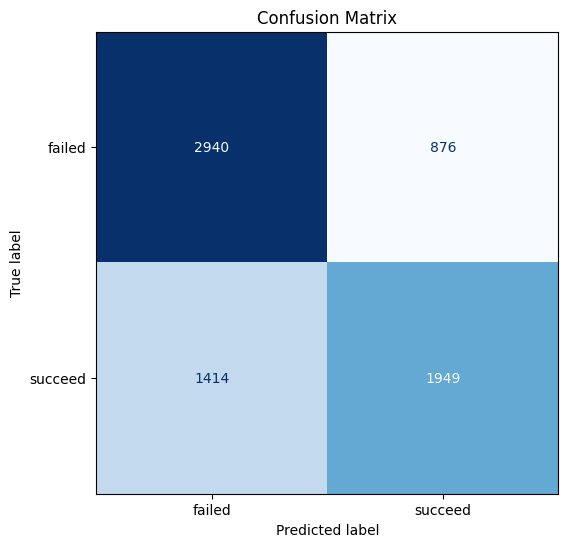


[NN] SHAP

[NN] SHAP - Importancia media de las features (|SHAP|)


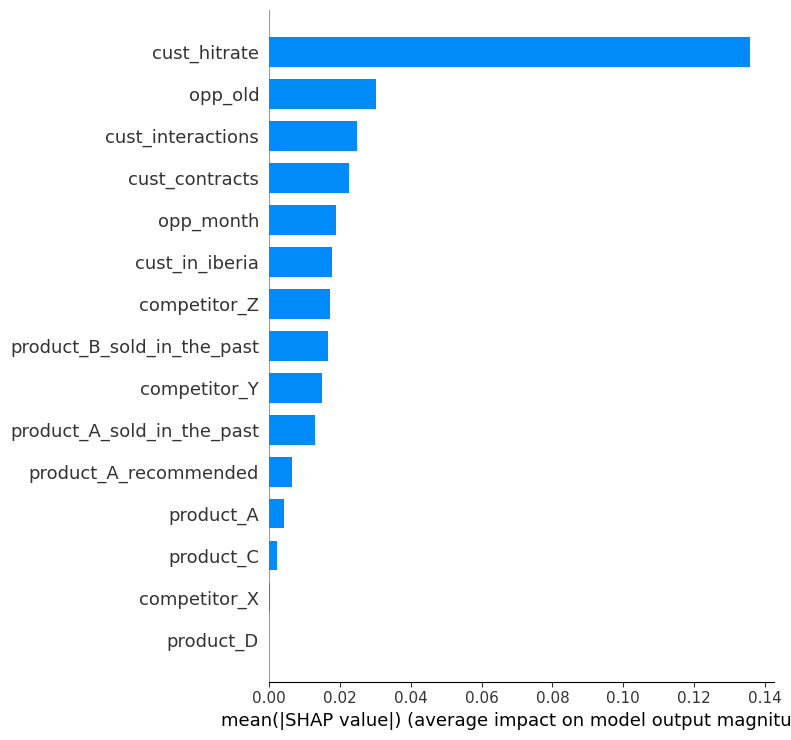


[NN] SHAP - Beeswarm


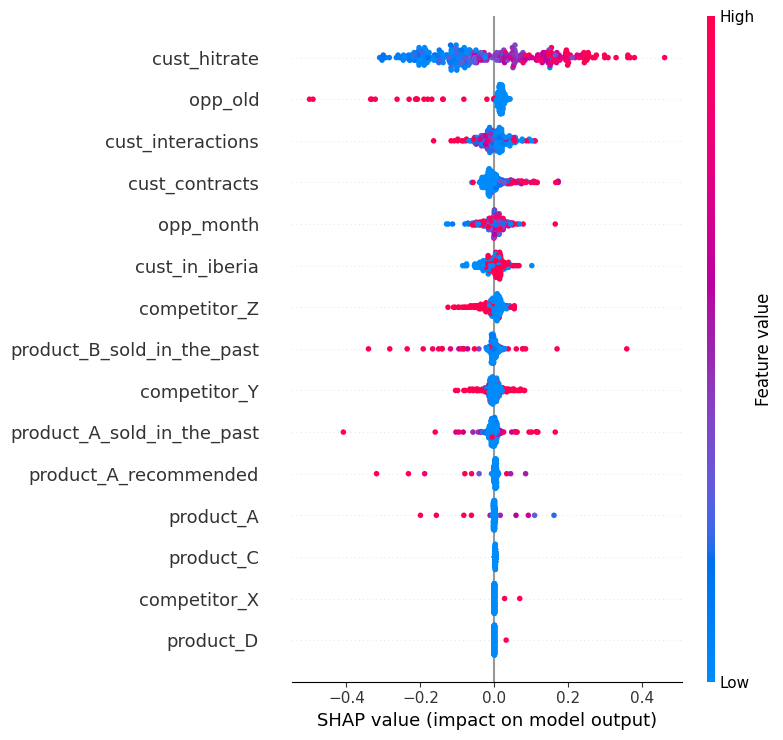


[NN] SHAP - Waterfall ejemplo 0 (clase positiva)


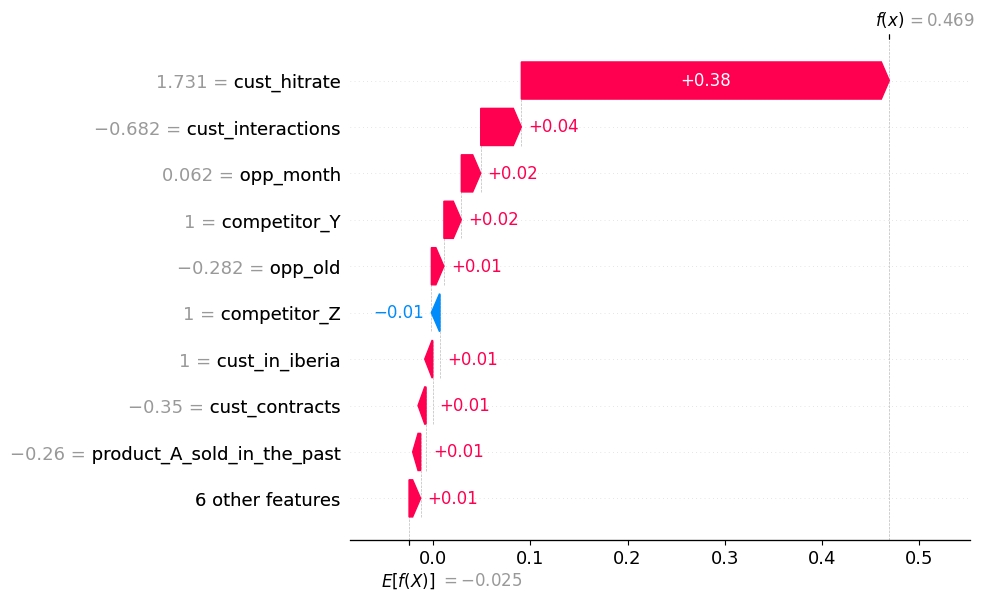


[NN] LIME

LIME para NN en índice 0
[('product_C <= -0.02', 0.3697232507040529), ('cust_hitrate > 0.85', 0.3191204912677547), ('opp_old <= -0.28', 0.2788805646504684), ('cust_contracts <= -0.35', -0.07379617960605175), ('competitor_X <= 0.00', -0.04942434212610118), ('cust_in_iberia <= 0.00', -0.04510842191005595), ('product_A <= -0.09', 0.03735235879659288), ('product_A_sold_in_the_past <= -0.26', -0.031802406294913155), ('product_A_recommended <= -0.11', 0.02290753638736098), ('product_B_sold_in_the_past <= -0.35', 0.021204567035069746)]


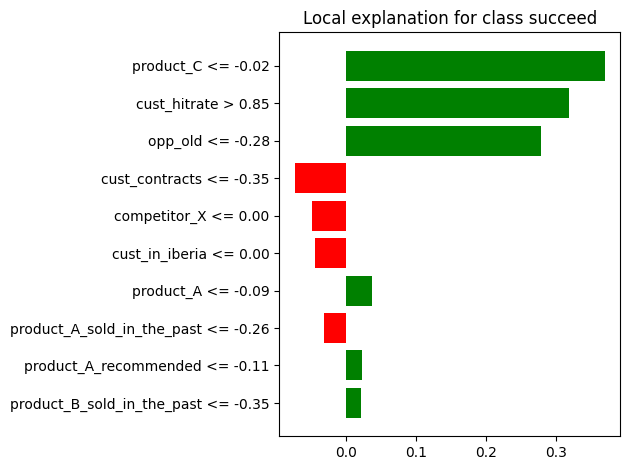


MODELO 2: DECISION TREE

[DT] Entrenando modelo...
Decision Tree Accuracy: 0.7437

Decision Tree Classification Report:
              precision    recall  f1-score   support

      failed       0.76      0.76      0.76      3816
     succeed       0.73      0.73      0.73      3363

    accuracy                           0.74      7179
   macro avg       0.74      0.74      0.74      7179
weighted avg       0.74      0.74      0.74      7179



In [ ]:
def main():
    # 1) Nombres de features y clases
    original_feature_names = [
        'product_A_sold_in_the_past',
        'product_B_sold_in_the_past',
        'product_A_recommended',
        'product_A',
        'product_C',
        'product_D',
        'cust_hitrate',
        'cust_interactions',
        'cust_contracts',
        'opp_month',
        'opp_old',
        'competitor_Z',
        'competitor_X',
        'competitor_Y',
        'cust_in_iberia'
    ]
    class_names = ['failed', 'succeed']

    # 2) Hiperparámetros y device
    BATCH_SIZE = 256
    LEARNING_RATE = 0.0008
    EPOCHS = 10
    torch.manual_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 3) Dataset y dataloaders (comunes para todos los modelos)
    train_dataset, test_dataset = process_dataset("dataset.csv")
    train_dataloader, test_dataloader = create_dataloader(
        train_dataset, test_dataset, BATCH_SIZE
    )

    # 4) Datos en numpy para sklearn / LIME / SHAP
    X_train = torch.stack([X for X, _ in train_dataset]).cpu().numpy()
    y_train = torch.stack([y for _, y in train_dataset]).cpu().numpy().astype(int)

    X_test = torch.stack([X for X, y in test_dataset]).cpu().numpy()
    y_test = torch.stack([y for X, y in test_dataset]).cpu().numpy().astype(int)

    print("X_train shape:", X_train.shape)
    print("len(original_feature_names):", len(original_feature_names))

    # 5) Explainer LIME común (lo reutilizamos para los 3 modelos)
    lime_explainer = create_lime_explainer(
        X_train=X_train,
        feature_names=original_feature_names,
        class_names=class_names
    )

    #NN
    print("\n======================")
    print("MODELO 1: RED NEURONAL")
    print("======================")

    # 1. Entrenar NN
    model = SchneiderModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    print("\n[NN] Entrenando modelo...")
    train(train_dataloader, model, loss_fn, optimizer, device, EPOCHS)
    test(test_dataloader, model, loss_fn, device)

    # SHAP NN
    print("\n[NN] SHAP")
    shap_nn_model(
      model,
      X_train,
      X_test,
      device=device,
     feature_names=original_feature_names
    )

    # LIME para NN
    print("\n[NN] LIME")
    lime_explain_nn_model(
        explainer=lime_explainer,
        model=model,
        device=device,
        X_test=X_test,
        instance_index=0,
        num_features=10
    )

    # Decision Tree
    print("\n==========================")
    print("MODELO 2: DECISION TREE")
    print("==========================")

    # Entrenar Decision Tree
    print("\n[DT] Entrenando modelo...")
    tree_clf = decision_tree_model(
        X_train, y_train, X_test, y_test,
        feature_names=original_feature_names
    )

    # Best Features segun Decision Tree
    print("\n[DT] Best Features")
    get_best_features(tree_clf, original_feature_names)

    # SHAP para Decision Tree
    print("\n[DT] SHAP")
    shap_tree_model(tree_clf, X_test, feature_names=original_feature_names)

    # LIME para Decision Tree
    print("\n[DT] LIME")
    lime_explain_sklearn_model(
        explainer=lime_explainer,
        model=tree_clf,
        X_test=X_test,
        instance_index=0,
        num_features=10
    )
    # Random Forest
    print("\n==========================")
    print("MODELO 3: RANDOM FOREST")
    print("==========================")

    # Entrenar Random Forest
    print("\n[RF] Entrenando modelo...")
    rf_clf = random_forest(X_train, y_train, X_test, y_test)

    # Best Features segun Random Forest
    print("\n[RF] Best Features")
    get_best_features(rf_clf, original_feature_names)

    # LIME para Random Forest
    print("\n[RF] LIME")
    lime_explain_sklearn_model(
        explainer=lime_explainer,
        model=rf_clf,
        X_test=X_test,
        instance_index=0,
        num_features=10
    )

    print(f"--- Permutation Importances Decision Tree---\n")
    permutation_importance_analysis(tree_clf, X_test, y_test, feature_names=original_feature_names)

    print(f"\n--- Permutation Importances Random Forest---\n")
    permutation_importance_analysis(rf_clf, X_test, y_test, feature_names=original_feature_names)

    print(f"\n--- Random Forest con K-Best Features---\n")
    X_train, y_train, X_test, y_test = select_k_best_features(X_train, y_train, X_test, y_test)
    forest_clf =random_forest(X_train, y_train, X_test, y_test)
main()
